In [64]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os.path import join

from IPython.display import Audio
from tensorflow.python.ops import math_ops
from keras.layers import Dense, LSTM, LeakyReLU, Input, Add
from keras.models import load_model
from keras.optimizers import Adam
from keras.saving import register_keras_serializable
from keras import Model
from scipy.io.wavfile import read, write

In [25]:
# Define constants
RATE = 44100
SAMPLE_SEC = 1 #Sample length in seconds
MODEL_DIR = 'Models'
DATA_DIR = 'Data'

# Splits the audio file into disjoint clips to be used as training examples
def sample(old, sample_cnt):
    new = np.empty((sample_cnt, RATE*SAMPLE_SEC))
    i=0
    for s in range(0, old.shape[0], RATE*SAMPLE_SEC):
        new[i] = old[s: s+RATE*SAMPLE_SEC]
        i+=1
    return new
    
def pre_process(filepath):
    # Read .wav file from filepath
    # Note : .wav bounced using LogicPro / Garageband adds 'LGWV' and 'cue ' chunks which causes
    #        scipy to throw a "WavFileWarning ... skipping it". Ignore it.
    _, wavfile = read(join(DATA_DIR, filepath))
    sample_cnt = wavfile.shape[0]//(RATE*SAMPLE_SEC)
    
    # Convert to Mono by dropping the second chanel (or first chanel, doesn't matter),
    # Then truncate to a multiple of sample length, ie, ignore partial sample left at the end
    wavfile = np.delete(wavfile, 1, 1)
    wavfile = [x[0] for x in wavfile[0: sample_cnt*SAMPLE_SEC*RATE]]
    wavfile = np.array(wavfile)
    
    # Reshape into dimentions for LSTM
    # Input dimentions for LSTM (#.examples, #.timesteps, #.features)
    wavfile = (sample(wavfile, sample_cnt)).reshape(sample_cnt, RATE*SAMPLE_SEC, -1)
    
    return wavfile

In [30]:
X_train = pre_process('X_train.wav')
Y_train = pre_process('Y_train.wav')
assert X_train.shape == Y_train.shape
print(X_train.shape)

/var/folders/27/q7qn8b856fl5vzn7wn3sc19h0000gn/T/ipykernel_83524/876646084.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, wavfile = read(join(DATA_DIR, filepath))


(52, 44100, 1)


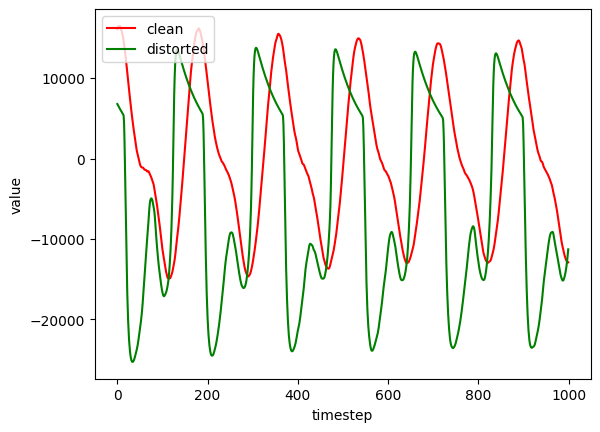

In [53]:
# Plot X_train and Y_train 
plt.plot(X_train[50][1000:2000], color='red')
plt.plot(Y_train[50][1000:2000], color='green')
plt.xlabel('timestep')
plt.ylabel('value')
plt.legend(['clean', 'distorted'], loc='upper left')
plt.show()

# Observation: Distorted signal closely follows clean closely
# but has high amplitude. Typical of Overdriven signal
# Also, Distorted seems to have lower troughs but marginally higher peaks, if any, when
# compared to clean signal

In [66]:
# Define Custom Loss
# MSE doesnt seem to work well. Quick google shows ESR Loss could help
@register_keras_serializable()
def ESRLoss(y_true, y_pred):
    loss = math_ops.squared_difference(y_pred, y_true) 
    loss = math_ops.mean(loss, axis=-1)
    energy = math_ops.mean(math_ops.pow(y_true, 2), axis=-1) + 0.00001
    loss = math_ops.div(loss, energy)
    return loss

In [55]:
# LSTM Model of the music data
# Since we are predicting a value for every timestep, we set return_sequences=True
input = Input(shape=(RATE*SAMPLE_SEC,1))
mLSTM = LSTM(units=32, return_sequences=True)(input)
mLSTM = LSTM(units=64, return_sequences=True)(mLSTM)
mLSTM = Dense(units=32, activation='linear')(mLSTM)

mDense = Dense(units=32, activation='linear')(input)
mSkip = Add()([mLSTM, mDense])

mDense = Dense(units=RATE*SAMPLE_SEC, activation='linear')(mSkip)

model = Model(input, mSkip)
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss=ESRLoss)
history = model.fit(X_train, Y_train, epochs=20, validation_split=0.3)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
2/2 [==============================] - 254s 112s/step - loss: 3191197.2500 - val_loss: 68535.9531


[3191197.25]


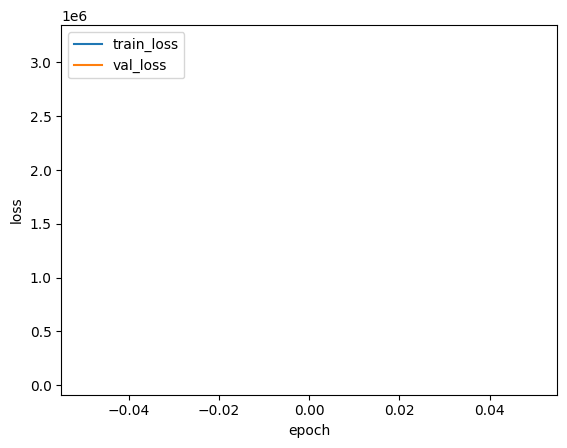

In [56]:
# Dummy data for testing GA later. Will use numbers arround this to build dummy fitness function
loss = history.history['loss']
print(loss)

# Plot train and val loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [59]:
# Save model
model.save(join(MODEL_DIR, 'v1.keras'))

In [67]:
# Load the model
model = load_model(join(MODEL_DIR, 'v1.keras'))

In [82]:
# Process the predicited output into .wav filw
def post_process(pred):
    wavfile = np.empty((pred.shape[0]*RATE*SAMPLE_SEC))
    for s in range(pred.shape[0]):
        for i in range(RATE*SAMPLE_SEC):
            wavfile[s+i] = pred[s][i][0]
    return wavfile

In [85]:
# Distort the test sample
X_test = pre_process('X_test.wav')
#Y_test = pre_process('Y_test.wav')
#assert X_test.shape == Y_test.shape

Y_pred = model.predict(X_test)

# saving the LSTM predicitons in wav format
write(join(DATA_DIR, 'Y_pred.wav'), RATE, post_process(Y_pred))

/var/folders/27/q7qn8b856fl5vzn7wn3sc19h0000gn/T/ipykernel_83524/876646084.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, wavfile = read(join(DATA_DIR, filepath))


1/1 [==============================] - 4s 4s/step


In [86]:
# Play Predicted sample
Audio(join(DATA_DIR, 'Y_pred.wav')) 

ValueError: rate must be specified when data is a numpy array or list of audio samples.